## CENÁRIO 01: MODELO ATEGO ATP 

IMPORTS

In [16]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas


### ETAPA 1 - Obtendo informações de tempo do Yamazumi

In [17]:


# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

In [18]:

# --- Dicionários ---
#Adaptação para o cenário 1
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951511", "C951514","C951501","C951530", "C951544"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 2, "tempos":"Yamazumi - ATP.csv"}, 
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
}

#Remoção do Atego (ATP)
ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego'],'operadores':1},
              'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego'],'operadores':1},
              'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego'],'operadores':1},
              '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
              'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
              'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego'],'operadores':1}, 
              'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego'],'operadores':1}, 
              'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego'],'operadores':1},
              'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
              'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
              'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego'],'operadores':1},
              'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego'],'operadores':1},
              'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego'],'operadores':1},
              'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
              'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego'],'operadores':1},
              'QUIS':{'postos':['38'],'modelos':['Accelo','Atego'],'operadores':1},
              }

#Adicionar novos carros que vão pra perna 2 e adaptar os postos da p1 paralelos a p2
ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':2},
              'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1}, 
              'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
              'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego (ATP)'],'operadores':1},
              'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
              'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0},
              
              #Atividades da p1 que foram para a p2
              'DIESEL':{'postos':['30B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ARREFEC':{'postos':['31B'],'modelos':['Atego (ATP)'],'operadores':1},
              'REAPERTO':{'postos':['32B'],'modelos':['Atego (ATP)'],'operadores':1},
              'ESTEPE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LE':{'postos':['32D'],'modelos':['Atego (ATP)'],'operadores':1},
              'APERTO_LD':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'GRADE':{'postos':['34B'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_1':{'postos':['34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MECACNICA_2':{'postos':['34A','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_1':{'postos':['33B','34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'ELACTRICA_2':{'postos':['33B','34B','39'],'modelos':['Atego (ATP)'],'operadores':1},
              'MOTORISTA':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
              'QUIS':{'postos':['39'],'modelos':['Atego (ATP)'],'operadores':1},
               }


In [19]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    GRUPOS_ESPECIAIS = {
        'P1': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "media"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
            'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
        },
        'P2': {
            'PNEU': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
            'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "paralama"},
            'APERTO': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "novo"},
            'MECACNICA': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "novo"},
            'ELETRICA': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "novo"},
            'ELECTRICA': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II'], "agreg": "novo"},
            'DIESEL_PASSADISSO': {'atividades': ['DIESEL', 'PASSADISASSO'], 'agreg': 'novo'},
            'ARREFEC_ABASTECIMENTO': {'atividades': ['ARREFEC', 'ABASTECIMENTO'], 'agreg': 'novo'},
            'REAPERTO_CHINELEIRA': {'atividades': ['REAPERTO', 'CHINELEIRA'], 'agreg': 'novo'},
            '5AA_RODA_ESTEPE': {'atividades': ['ESTEPE', '5AA_RODA'], 'agreg': 'novo'},
            'GRADE_CONTROLE_MOTORISTA_QUIS':{'atividades': ['GRADE','CONTROLE','MOTORISTA','QUIS'], 'agreg': 'novo'},
        }
    }

    atividades_unicas_por_perna = {1: set(), 2: set()}

    for modelo, dados_modelo in MODELOS_CSV.items():
        #print(modelo)
        perna = dados_modelo["perna"]
        arquivo = dados_modelo["tempos"]
        tempos_atividade = get_process_times_from_csv(arquivo)

        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2
        grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

        dicionario_postos = {}

        for nome_grupo, grupo in grupos.items():
            atividades = grupo["atividades"]
            if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
                continue

            for a in atividades:
                atividades_unicas_por_perna[perna].add(a)

            if grupo["agreg"] == "media":
                tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
                tempo = tempo_total / len(atividades)
            elif grupo["agreg"] == "paralama":
                tempo_total = sum(tempos_atividade[a] for a in atividades)
                total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades)/2
                tempo = tempo_total / total_operadores
            elif grupo["agreg"] == "novo":
                tempo_total = sum(tempos_atividade[a] for a in atividades)
                total_operadores = 1  # REGRA NOVA: apenas 1 operador realiza todas as atividades do grupo
                tempo = tempo_total / total_operadores
            else:
                continue

            postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
            for posto in postos_grupo:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo / len(postos_grupo)

        for atividade, props in atividades_dict.items():
            if modelo not in props['modelos']:
                continue
            if atividade not in tempos_atividade:
                continue

            atividades_unicas_por_perna[perna].add(atividade)

            tempo = tempos_atividade[atividade] / props['operadores']
            for posto in props['postos']:
                dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
                dicionario_postos[posto]["tempo_tot"] += tempo

        postos_ordenados = {}
        for posto in ordem_postos:
            if posto in dicionario_postos:
                postos_ordenados[posto] = dicionario_postos[posto]

        POSTOS[modelo] = postos_ordenados
    operadores = {1: 0, 2: 0}
    for perna in [1, 2]:
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

        # Atividades já consideradas via grupo 'novo'
        atividades_em_grupos_novo = set()
        for grupo in grupos.values():
            if grupo['agreg']=='novo':
                atividades_em_grupos_novo.update(grupo["atividades"])
                operadores[perna] += 1
 
        # print(atividades_em_grupos_novo)

        # Agora conta as atividades que não fazem parte de grupo 'novo'
        for atividade in atividades_unicas_por_perna[perna]:
            if atividade not in atividades_em_grupos_novo:
                #print(atividade,atividades_dict[atividade]['operadores'])
                operadores[perna] += atividades_dict[atividade]["operadores"]

    print(f"\n👷‍♂️ Operadores totais por perna:")
    for perna in [1, 2]:
        print(f"  Perna {perna}: {operadores[perna]} operadores")

    return POSTOS, operadores


In [20]:
POSTOS, operadores = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
for modelo, valor in POSTOS.items():
    print(f"{modelo}: {valor}")


👷‍♂️ Operadores totais por perna:
  Perna 1: 16 operadores
  Perna 2: 13 operadores
Accelo: {'30A': {'tempo_tot': 253.0, 'perna': 1}, '31A': {'tempo_tot': 316.0, 'perna': 1}, '32A': {'tempo_tot': 1068.0, 'perna': 1}, '32C': {'tempo_tot': 1579.0, 'perna': 1}, '33A': {'tempo_tot': 1583.0, 'perna': 1}, '34A': {'tempo_tot': 1476.0, 'perna': 1}, '38': {'tempo_tot': 1021.0, 'perna': 1}}
Atego: {'30A': {'tempo_tot': 314.0, 'perna': 1}, '31A': {'tempo_tot': 314.0, 'perna': 1}, '32A': {'tempo_tot': 1134.0, 'perna': 1}, '32C': {'tempo_tot': 1579.5, 'perna': 1}, '33A': {'tempo_tot': 1764.0, 'perna': 1}, '34A': {'tempo_tot': 1466.5, 'perna': 1}, '38': {'tempo_tot': 1021.0, 'perna': 1}}
Atego (ATP): {'30B': {'tempo_tot': 326.0, 'perna': 2}, '31B': {'tempo_tot': 330.0, 'perna': 2}, '32B': {'tempo_tot': 557.0, 'perna': 2}, '32D': {'tempo_tot': 1927.5, 'perna': 2}, '33B': {'tempo_tot': 1728.0, 'perna': 2}, '34B': {'tempo_tot': 2954.8333333333335, 'perna': 2}, '39': {'tempo_tot': 2533.8333333333335, '

### ETAPA 03: Processamento da simulação 

In [21]:
TAKT_TIME=5.5*60
TURN_DURATION=14*3600

# Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# env é o ambiente de simulação do SimPy.
# nome é o nome único desse modelo na simulação, ex: "Actros_5".
# postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

log_entrada_saida=[]
def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
            entrada = env.now
            yield req #espera se necessário (yield req)
            yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
            saida = env.now

            # registra entrada, saída e duração no log
            log_entrada_saida.append({
                "modelo": modelo_nome,
                "nome": nome,
                "posto": posto,
                "entrada": entrada,
                "saida": saida,
                "duracao": saida - entrada,
                "perna": perna
            })

# Função SIMULACAO_LINHA cria o ambiente da simulação
# recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

    env = simpy.Environment() # criando ambiente simulação
    
    # Ferramentas auxiliares na função:
    recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
    ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
    disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

    # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
    def alimentador(env):
        nonlocal ultimo_tempo_entrada_global

        # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
        for i, baumuster in enumerate(sequencia_modelos):
            modelo_nome, perna = None, None
            for nome, dados in MODELOS_CSV.items():
                if baumuster in dados["baumuster"]:
                    modelo_nome = nome
                    perna = dados["perna"]
                    break
            if modelo_nome is None:
                continue
            
            # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
            postos_dict = resultado[modelo_nome]
            primeiro_posto = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

            # Inicializa a disponibilidade se for a primeira vez usando esse posto
            if primeiro_posto not in disponibilidade_postos:
                disponibilidade_postos[primeiro_posto] = 0
            
            # só entra um modelo por vez no primeiro posto de cada perna;
            # o espaçamento entre modelos é de ao menos TAKT_TIME;
            # respeita o tempo mínimo em que o posto estará livre.

            # Espera até que seja possível entrar na linha
            tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
                tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
            )

            yield env.timeout(entrada_sugerida - env.now)

            # Atualiza os controles de entrada
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # Inicia processo de montagem
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna,
                postos_dict=postos_dict,
                recursos=recursos
            ))
    
    # Inicia simulação, rodando até duração do turno
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    return pd.DataFrame(log_entrada_saida)


### ETAPA 04 : Criando funções de resposta gráfica  

In [22]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [23]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(14, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [24]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)
    print(modelos_produzidos)

    fig, ax = plt.subplots(figsize=(15, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [25]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [26]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    print(modelos_completos)

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [27]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [28]:
# GRÁFICO ESPECIAL INDEPENDE DE DFLOG
def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    lista_dados = []

    # 1. Construir a lista de dados com tempos por modelo, atividade e posto
    for modelo, props in MODELOS_CSV.items():
        perna = props["perna"]
        arquivo = props["tempos"]
        atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
        ordem_postos = ordem_P1 if perna == 1 else ordem_P2

        tempos_atividade = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        for atividade, dados in atividades_dict.items():
            if modelo not in dados["modelos"]:
                continue

            tempo_total = tempos_atividade.get(atividade, 0)
            tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

            for posto in dados["postos"]:
                lista_dados.append({
                    "modelo": modelo,
                    "atividade": atividade,
                    "posto": posto,
                    "tempo_min": tempo_por_operador / 60,
                    "perna": perna
                })

    df_atividades = pd.DataFrame(lista_dados)

    def ordenar_por_posto(df, ordem_postos):
        df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
        return df.sort_values(["ordem_posto", "atividade"])

    # 2. Gerar gráfico para cada modelo
    modelos = df_atividades["modelo"].unique()
    figs =[]
    
    for modelo in modelos:
        df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
        perna = df_modelo["perna"].iloc[0]
        ordem = ordem_P1 if perna == 1 else ordem_P2
        df_modelo = ordenar_por_posto(df_modelo, ordem)

        linha_meta = 5.5 if perna == 1 else 16.5
        
        fig, ax = plt.subplots(figsize=(20, 9))
        sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
        plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
        plt.title(f"Tempo por Atividade - {modelo}")
        plt.xlabel("Atividade")
        plt.ylabel("Tempo por posto (minutos)")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        figs.append(fig)

    return figs 


Resumo da simulação em pdf

In [29]:

def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia.
    """

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio (em minutos)
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Novo Takt time real por perna (em minutos)
    takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
    linhas.append("Modelos produzidos por perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {perna}: {qtd} modelos")

    linhas.append("\nTempo médio de produção por modelo:")
    for perna, tempo in tempo_medio_producao.items():
        linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

    linhas.append("\nTakt time médio por posto:")
    for perna, takt in takt_time_medio.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    linhas.append("\nNovo Takt time real (TURN_DURATION / produção):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4

    c.setFont("Helvetica", 12)
    y = height - 40

    for linha in linhas:
        c.drawString(40, y, linha)
        y -= 20
        if y < 40:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 40

    c.save()
    print(f"📝 PDF salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

🗓️ Dias selecionados (5 a partir de 2025-04-10):
  - 2025-04-10
  - 2025-04-11
  - 2025-04-14
  - 2025-04-15
  - 2025-04-16


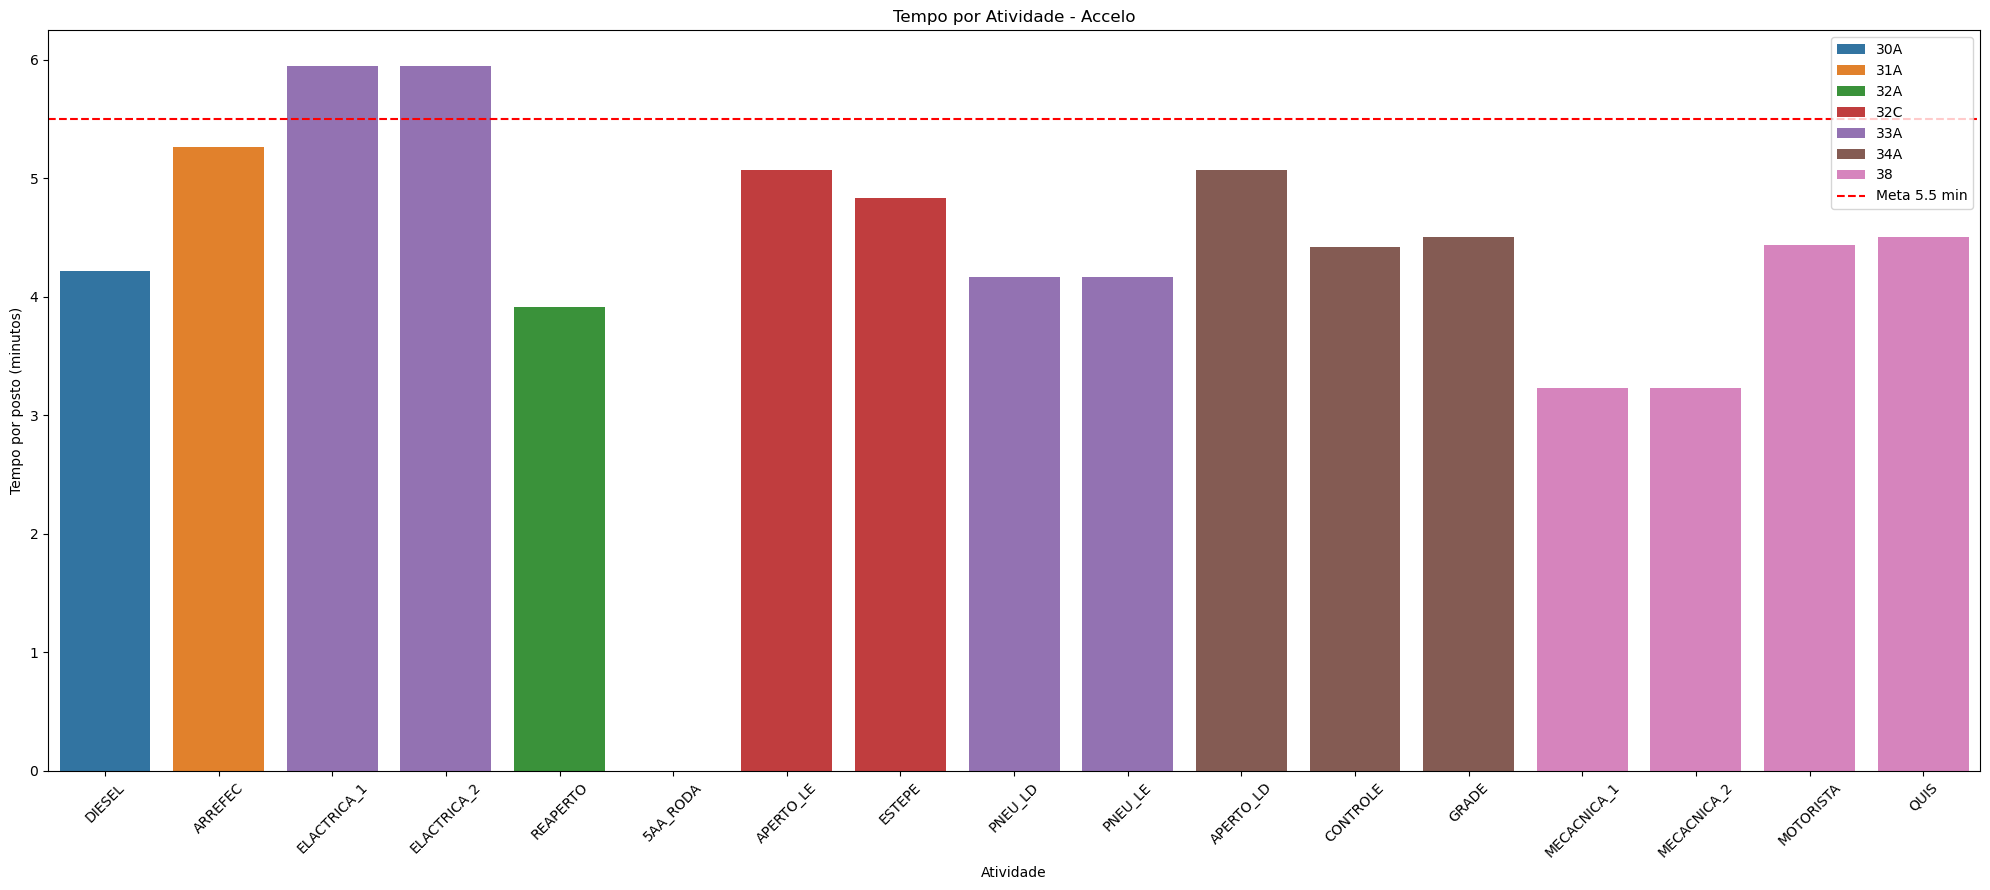

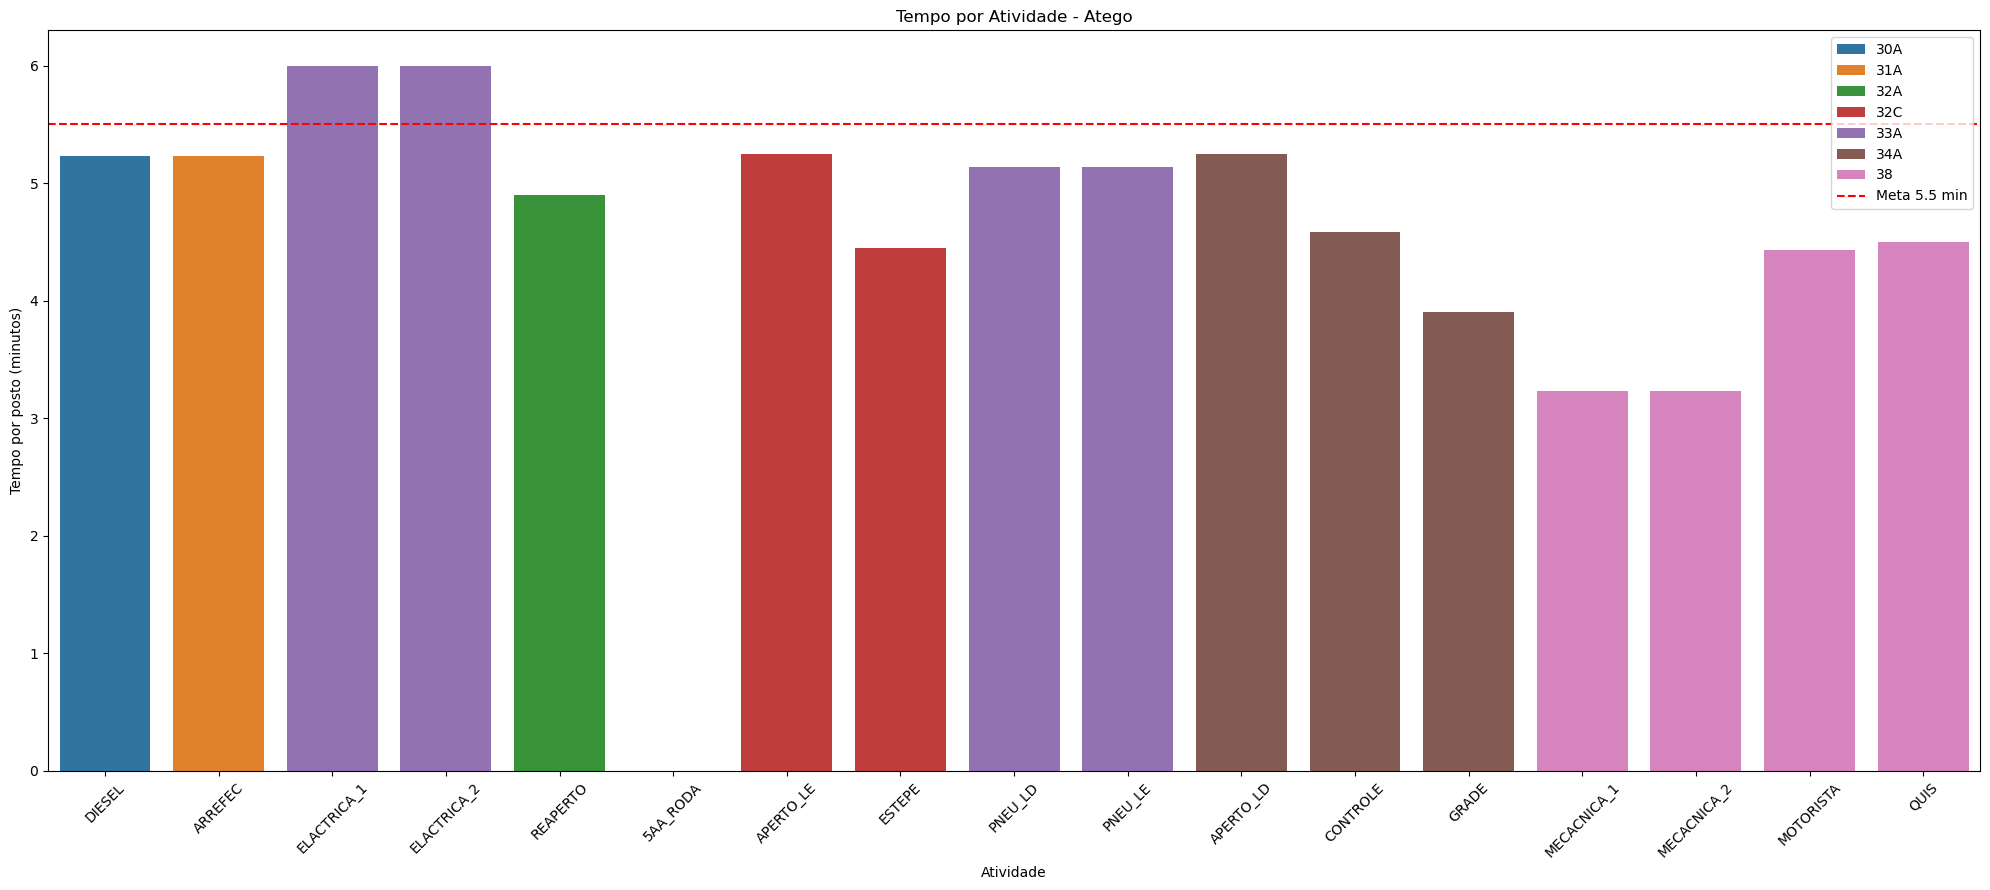

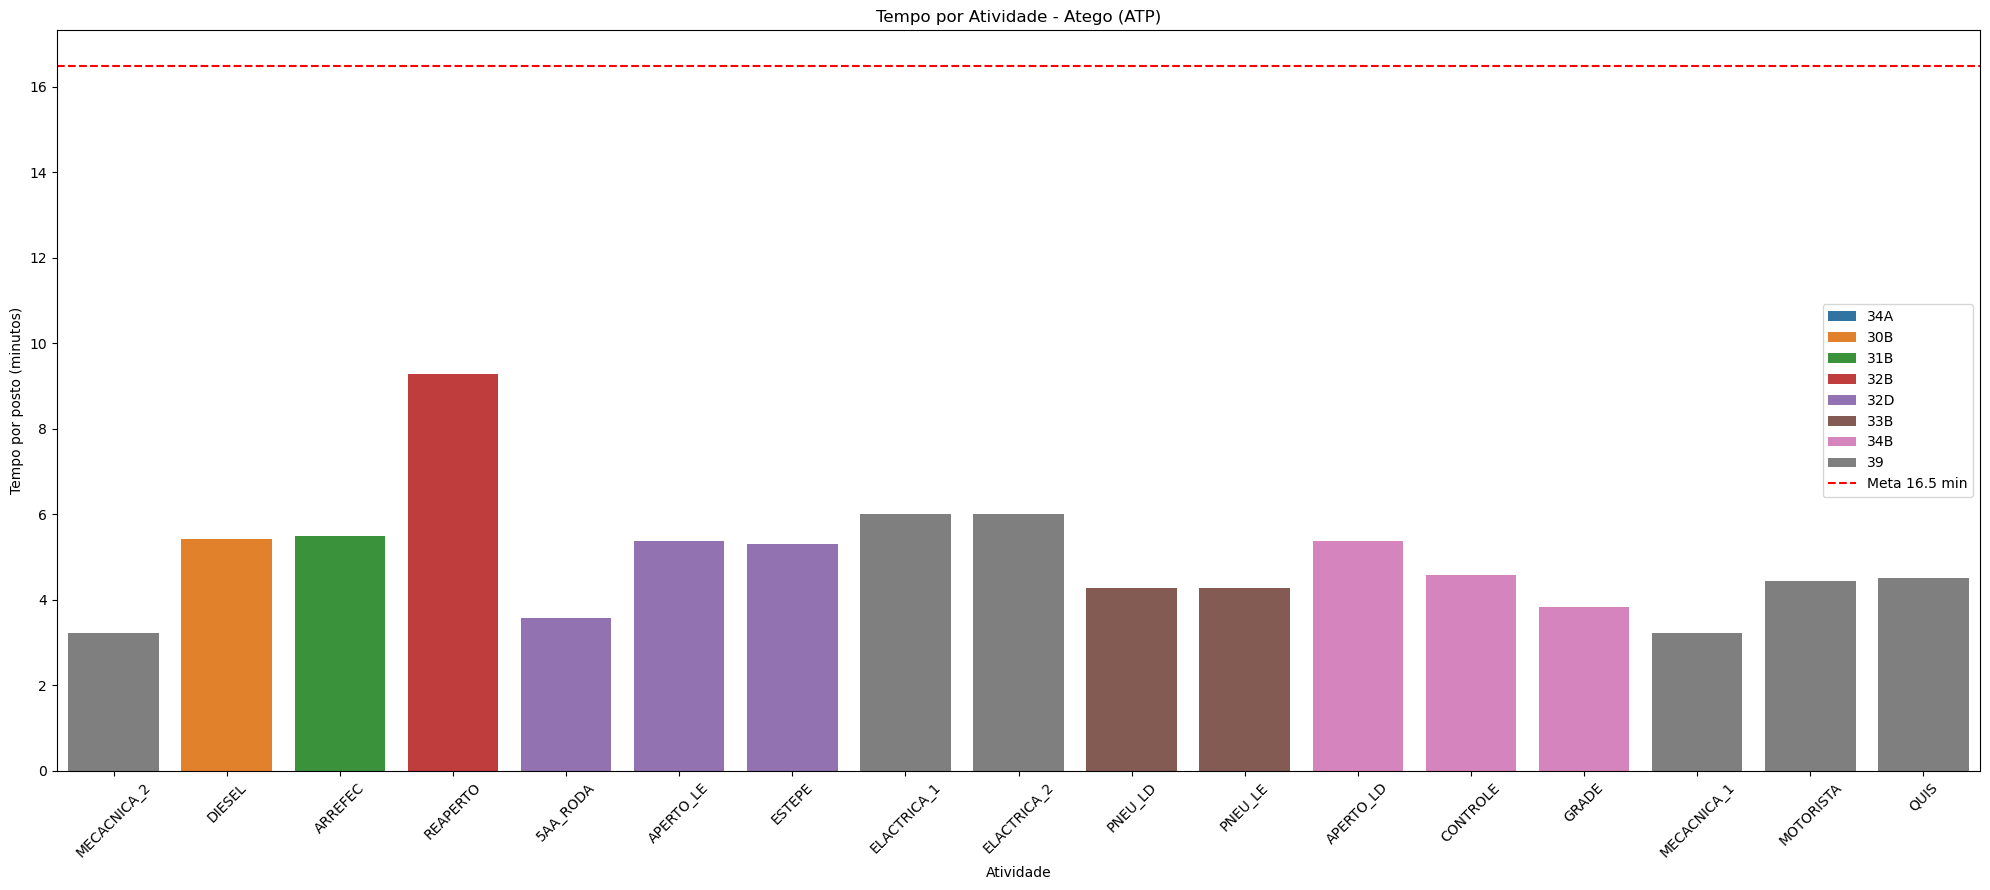

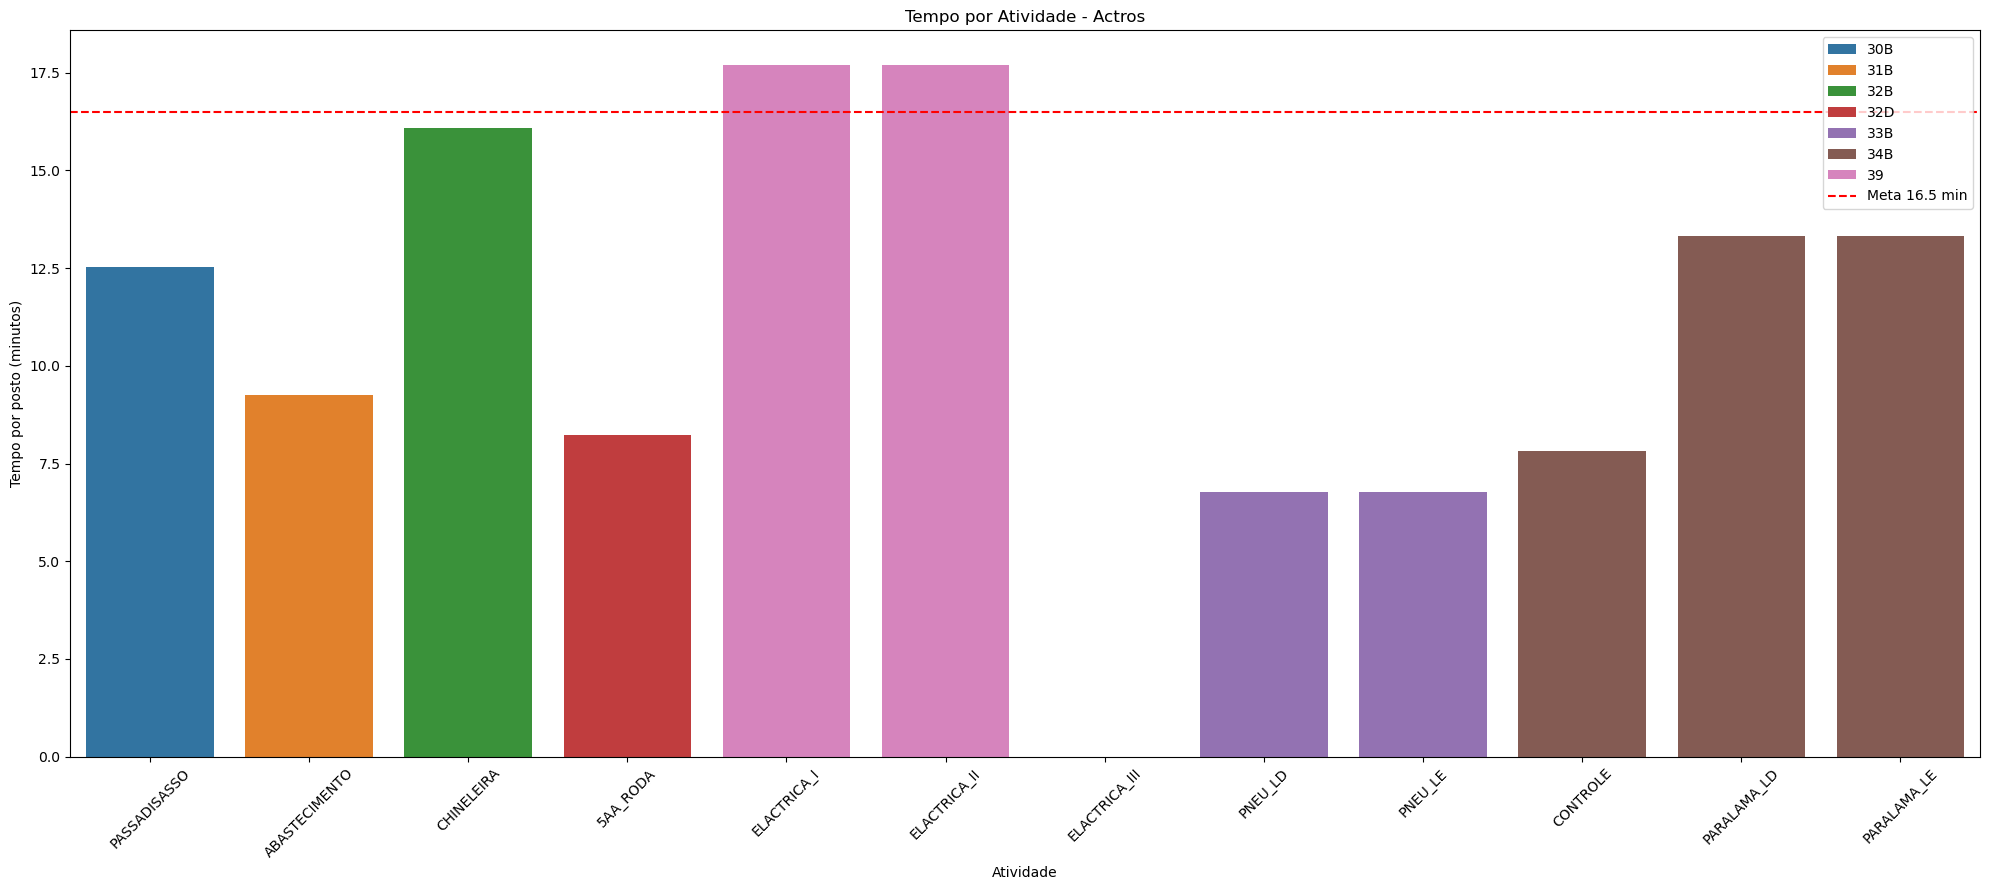

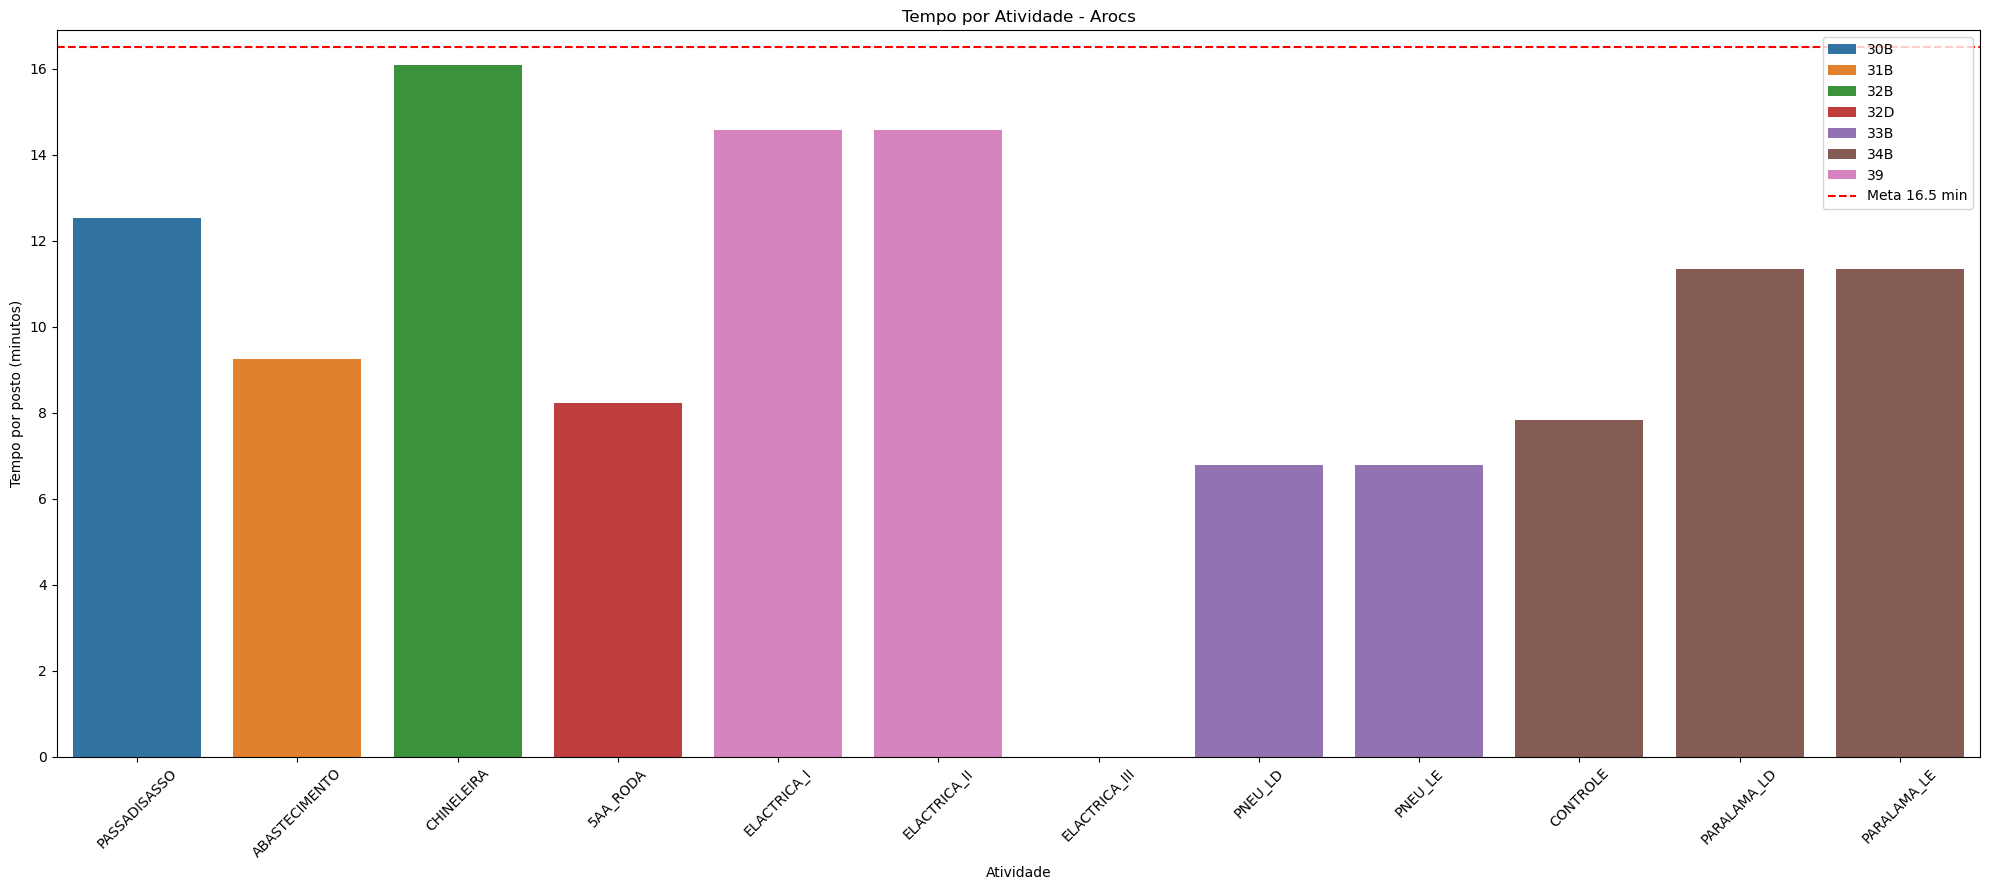

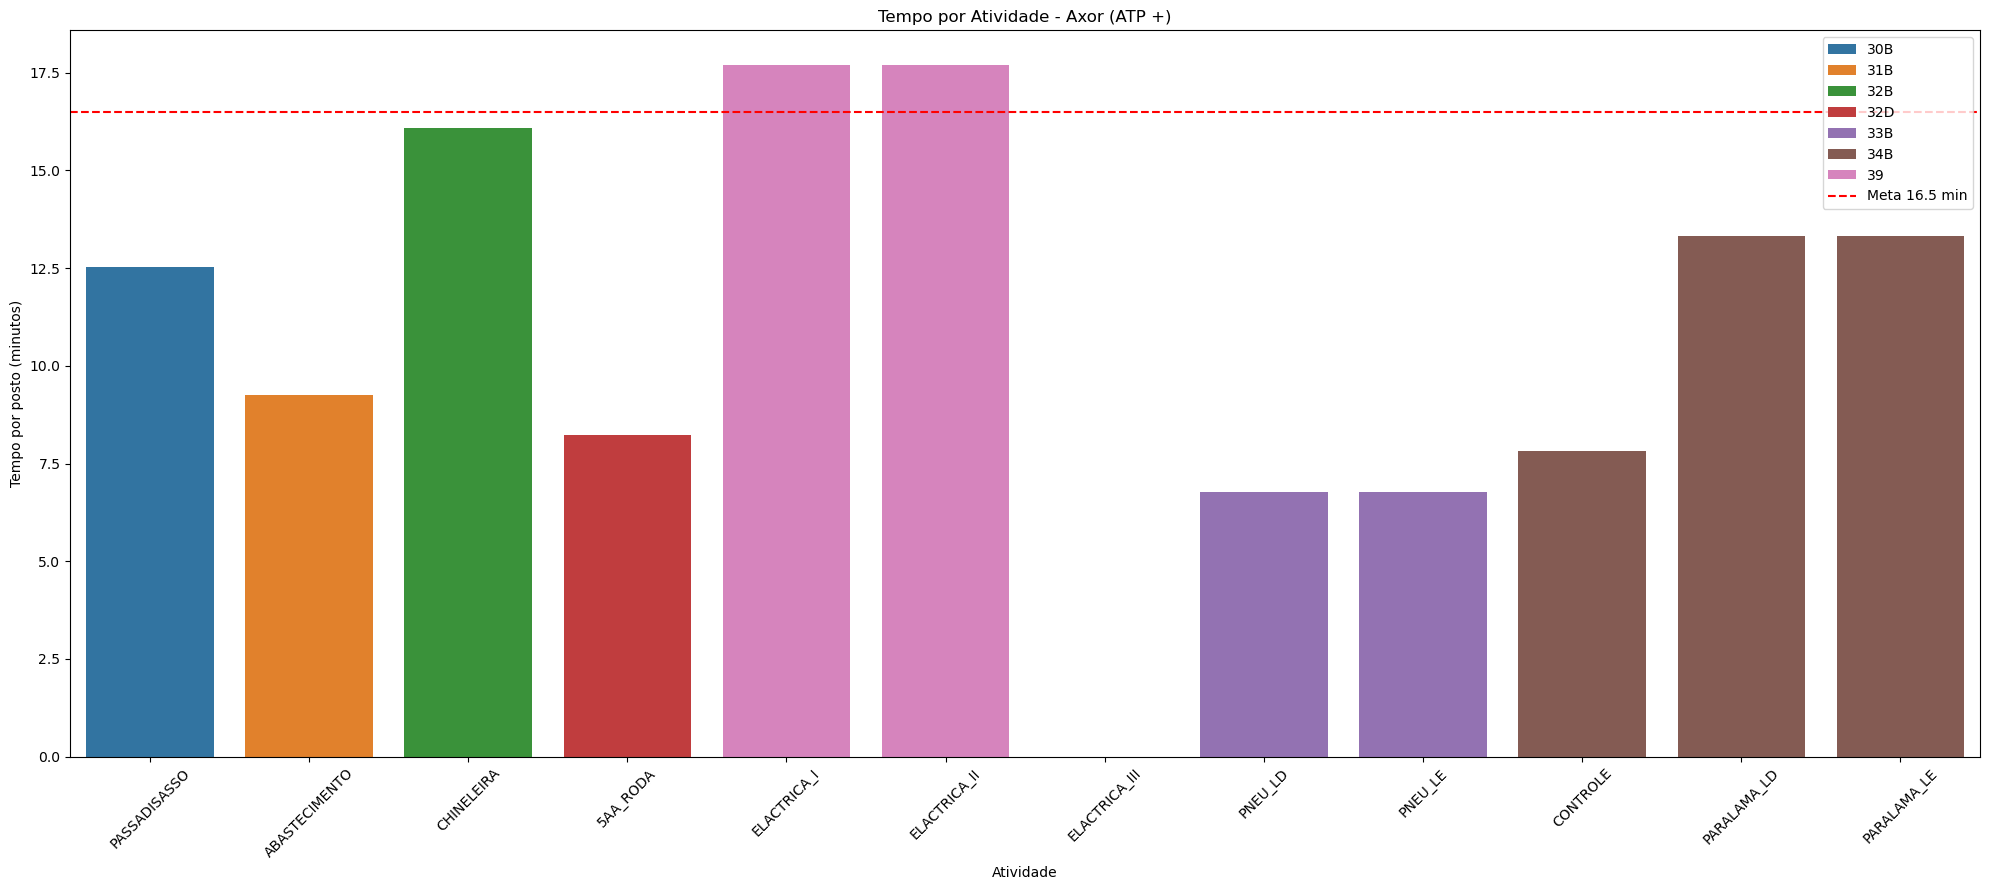


🔄 Processando o dia: 2025-04-10
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
27081 2025-04-10 05:46:32    C96840312 1932        C968403
18513 2025-04-10 05:51:26       C9515011268        C951501
24924 2025-04-10 05:56:14  C9515011248 1719        C951501
16332 2025-04-10 06:04:04         C96341112        C963411
22819 2025-04-10 06:09:03  C9511041246 1117        C951104
31326 2025-04-10 06:16:03  C9511041239 1117        C951104
31327 2025-04-10 06:20:51       C9515111274        C951511
3345  2025-04-10 06:27:17    C96840312 1932        C968403
20691 2025-04-10 06:32:43  C9515011262 1732        C951501
31328 2025-04-10 06:41:28  C9515111248 2433        C951511


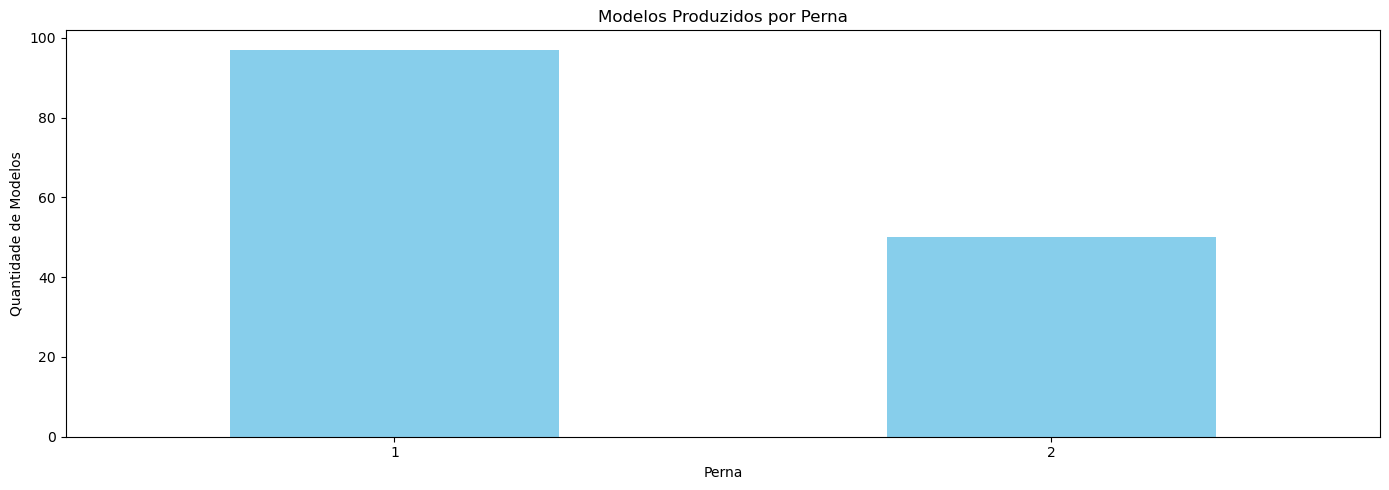

modelo
Atego          59
Accelo         38
Actros         27
Atego (ATP)    23
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_12816\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0    Accelo_106  Accelo      1        36338.0      36907.0
1    Accelo_111  Accelo      1        37988.0      38557.0
2    Accelo_112  Accelo      1        38318.0      38887.0
3    Accelo_114  Accelo      1        38978.0      39547.0
4    Accelo_120  Accelo      1        40958.0      41572.0
..          ...     ...    ...            ...          ...
142    Atego_84   Atego      1        28986.0      29614.0
143     Atego_9   Atego      1         3300.0      18475.0
144    Atego_90   Atego      1        30966.0      31594.0
145    Atego_93   Atego      1        31956.0      32584.0
146    Atego_97   Atego      1        33368.0      33996.0

[147 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_12816\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


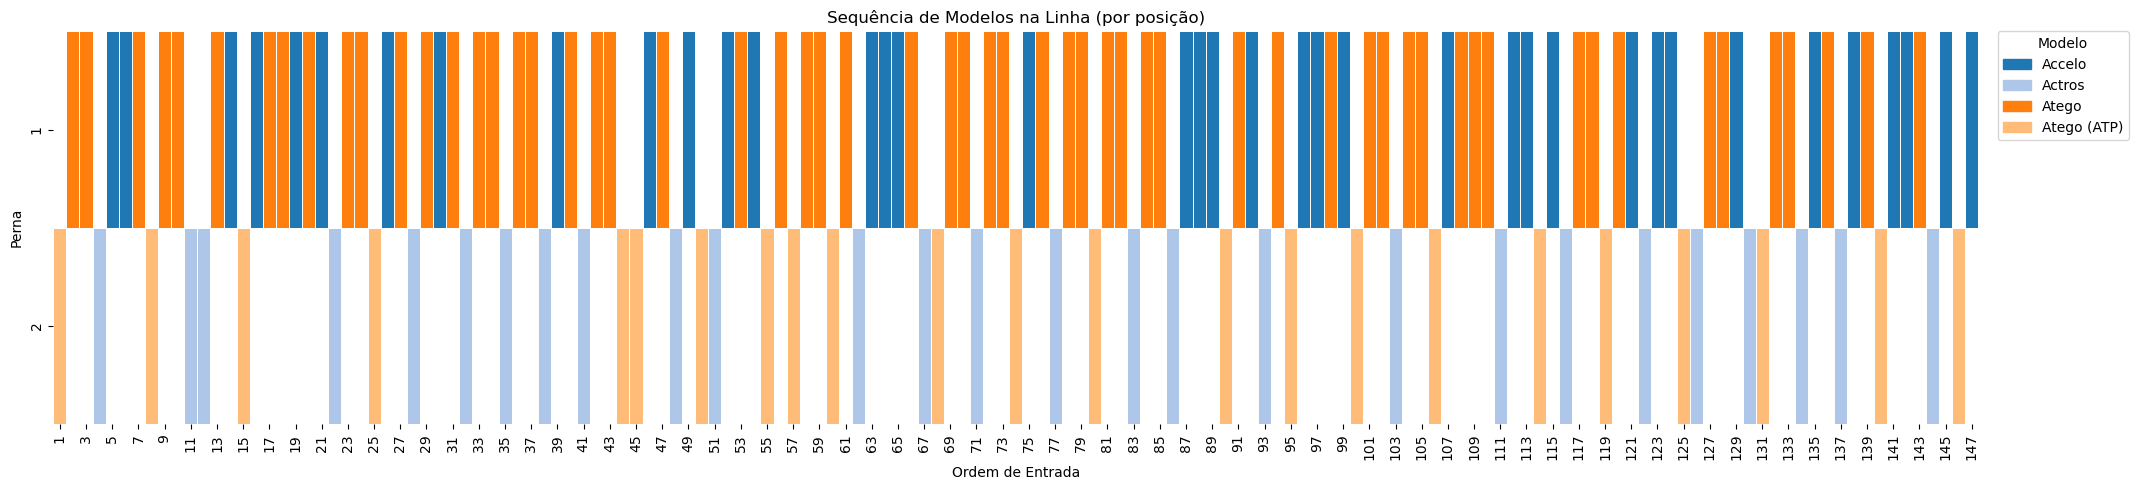

C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C1_ATP/2025-04-10/log_2025-04-10.csv
📝 PDF salvo em: logs_C1_ATP/2025-04-10/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-11
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
12373 2025-04-11 05:50:36  C9511041239 1017        C951104
33740 2025-04-11 05:56:53  C9511041246 1017        C951104
27327 2025-04-11 06:01:18       C9515011268        C951501
3605  2025-04-11 06:06:30  C9515111248 2433        C951511
14525 2025-04-11 06:13:02  C9634241215 2651        C963424
16620 2025-04-11 06:17:48       C9515011268        C951501
3606  2025-04-11 06:26:00    C96840312 1932        C968403
10150 2025-04-11 06:31:03       C9515111274        C951511
3607  2025-04-11 06:36:02       C9515111274        C951511
33742 2025-04-11 06:41:02  C9511111246 1317        C951111


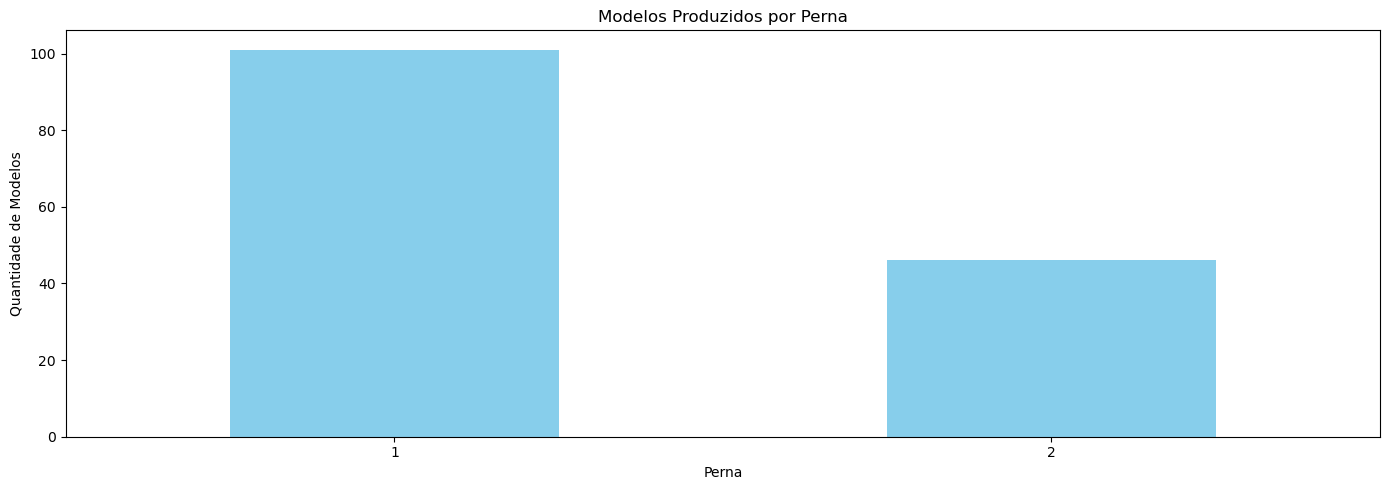

modelo
Atego           65
Accelo          36
Atego (ATP)     23
Actros          21
Arocs            1
Axor (ATP +)     1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_12816\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


                nome        modelo  perna  entrada_total  saida_total
0           Accelo_0        Accelo      1          330.0       7626.0
1           Accelo_1        Accelo      1          660.0       9209.0
2         Accelo_104        Accelo      1        35110.0      35724.0
3         Accelo_107        Accelo      1        36100.0      36714.0
4         Accelo_109        Accelo      1        36760.0      37329.0
..               ...           ...    ...            ...          ...
142         Atego_88         Atego      1        29738.0      30366.0
143         Atego_90         Atego      1        30398.0      31026.0
144         Atego_93         Atego      1        31388.0      32016.0
145         Atego_97         Atego      1        32800.0      33428.0
146  Axor (ATP +)_94  Axor (ATP +)      2        31718.0      41776.0

[147 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_12816\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


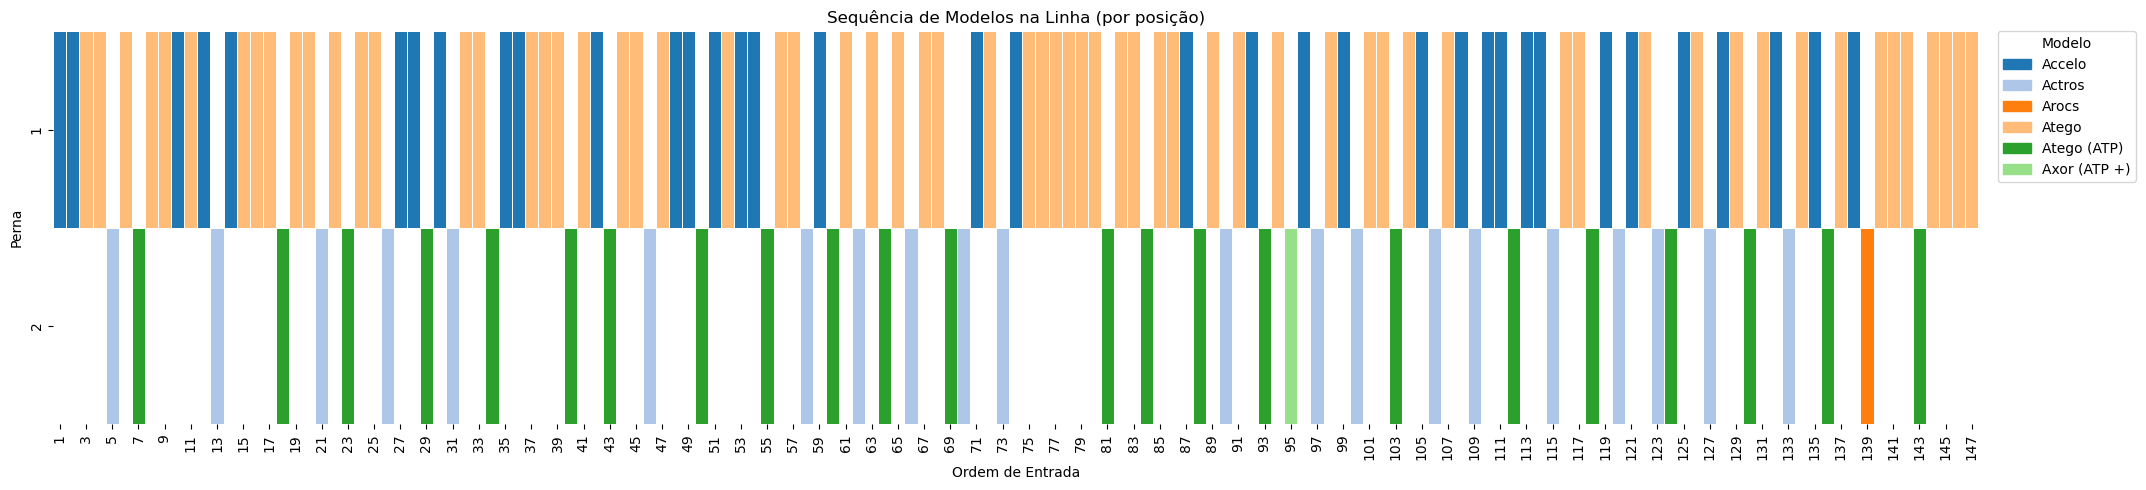

C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C1_ATP/2025-04-11/log_2025-04-11.csv
📝 PDF salvo em: logs_C1_ATP/2025-04-11/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-14
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
25344 2025-04-14 05:47:26  C9511111239 1317        C951111
16788 2025-04-14 05:53:42    C96840312 1932        C968403
1589  2025-04-14 06:00:28  C9511041246 1017        C951104
8118  2025-04-14 06:08:05  C9634251233 2545        C963425
31732 2025-04-14 06:13:46  C9515011268 1726        C951501
27502 2025-04-14 06:18:59  C9511041246 1017        C951104
10296 2025-04-14 06:25:12    C96840312 1932        C968403
1415  2025-04-14 06:30:50  C9515011268 1721        C951501
16789 2025-04-14 06:37:22       C9515111274        C951511
16790 2025-04-14 06:46:54  C9511041239 1017        C951104


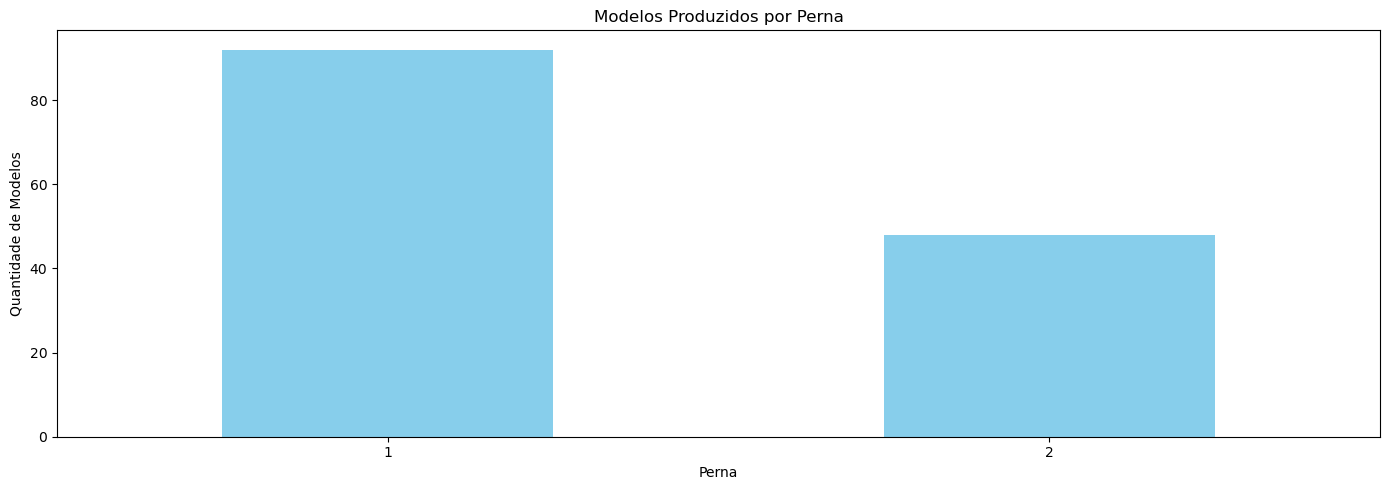

modelo
Atego          50
Accelo         42
Actros         25
Atego (ATP)    22
Arocs           1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_12816\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       7626.0
1     Accelo_10  Accelo      1         3630.0      19250.0
2    Accelo_103  Accelo      1        34926.0      35495.0
3    Accelo_107  Accelo      1        36246.0      36815.0
4     Accelo_11  Accelo      1         3960.0      20833.0
..          ...     ...    ...            ...          ...
135    Atego_87   Atego      1        29646.0      30274.0
136    Atego_89   Atego      1        30306.0      30934.0
137    Atego_92   Atego      1        31296.0      31924.0
138    Atego_94   Atego      1        31956.0      32584.0
139    Atego_97   Atego      1        32946.0      33574.0

[140 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_12816\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


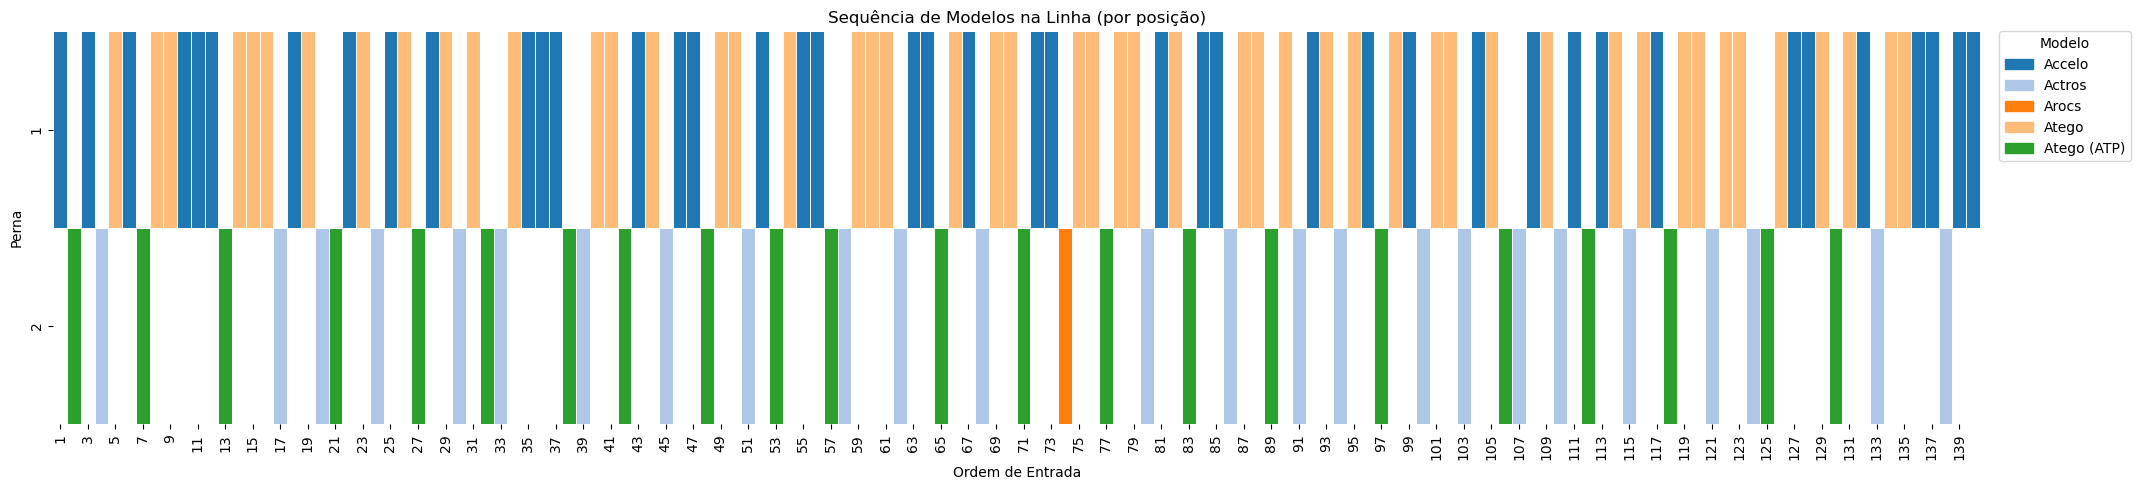

C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C1_ATP/2025-04-14/log_2025-04-14.csv
📝 PDF salvo em: logs_C1_ATP/2025-04-14/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-15
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
6075  2025-04-15 05:47:25  C9511041239 1017        C951104
10438 2025-04-15 05:55:39  C9634251233 2545        C963425
25477 2025-04-15 06:00:49       C9515111278        C951511
8259  2025-04-15 06:06:45   C9511021239 817        C951102
6076  2025-04-15 06:15:05    C96840312 1932        C968403
27630 2025-04-15 06:20:25  C9515441263 3033        C951544
23090 2025-04-15 06:26:58  C9515011268 1721        C951501
10439 2025-04-15 06:44:28  C9511111239 1317        C951111
27631 2025-04-15 06:50:17    C96341412 2653        C963414
8260  2025-04-15 06:55:16       C9515011268        C951501


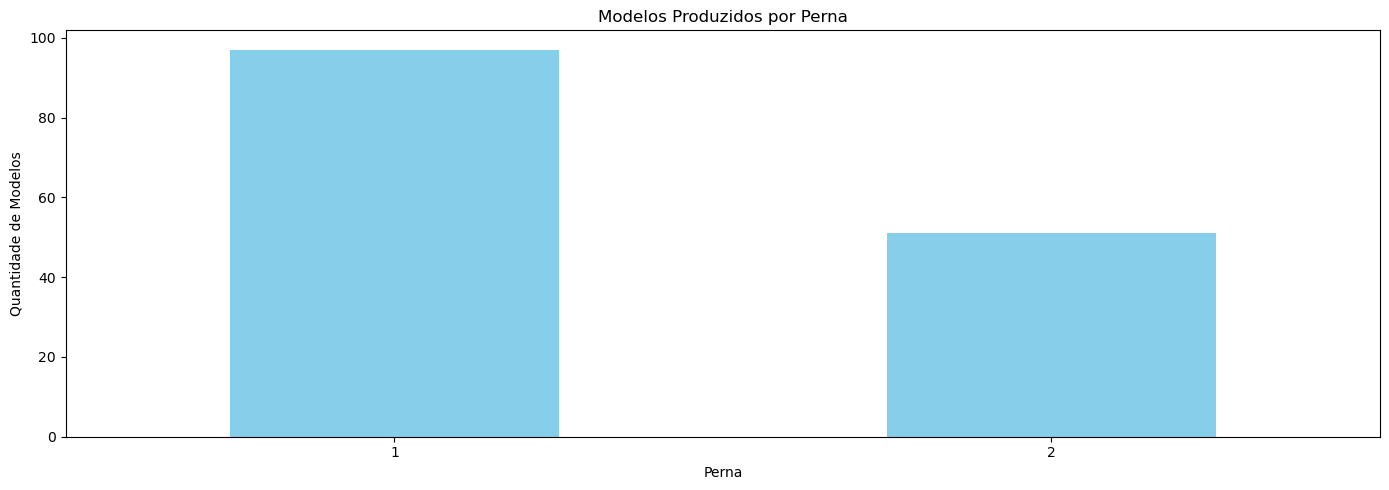

modelo
Atego           58
Accelo          39
Actros          26
Atego (ATP)     23
Arocs            1
Axor (ATP +)     1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_12816\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


                nome        modelo  perna  entrada_total  saida_total
0           Accelo_0        Accelo      1          330.0       7626.0
1          Accelo_10        Accelo      1         3630.0      19431.0
2         Accelo_100        Accelo      1        33936.0      34505.0
3         Accelo_103        Accelo      1        34926.0      35495.0
4         Accelo_106        Accelo      1        35916.0      36485.0
..               ...           ...    ...            ...          ...
143         Atego_93         Atego      1        31204.0      31832.0
144         Atego_94         Atego      1        31534.0      32162.0
145         Atego_96         Atego      1        32194.0      32822.0
146         Atego_97         Atego      1        32524.0      33152.0
147  Axor (ATP +)_54  Axor (ATP +)      2        18242.0      25885.5

[148 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_12816\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


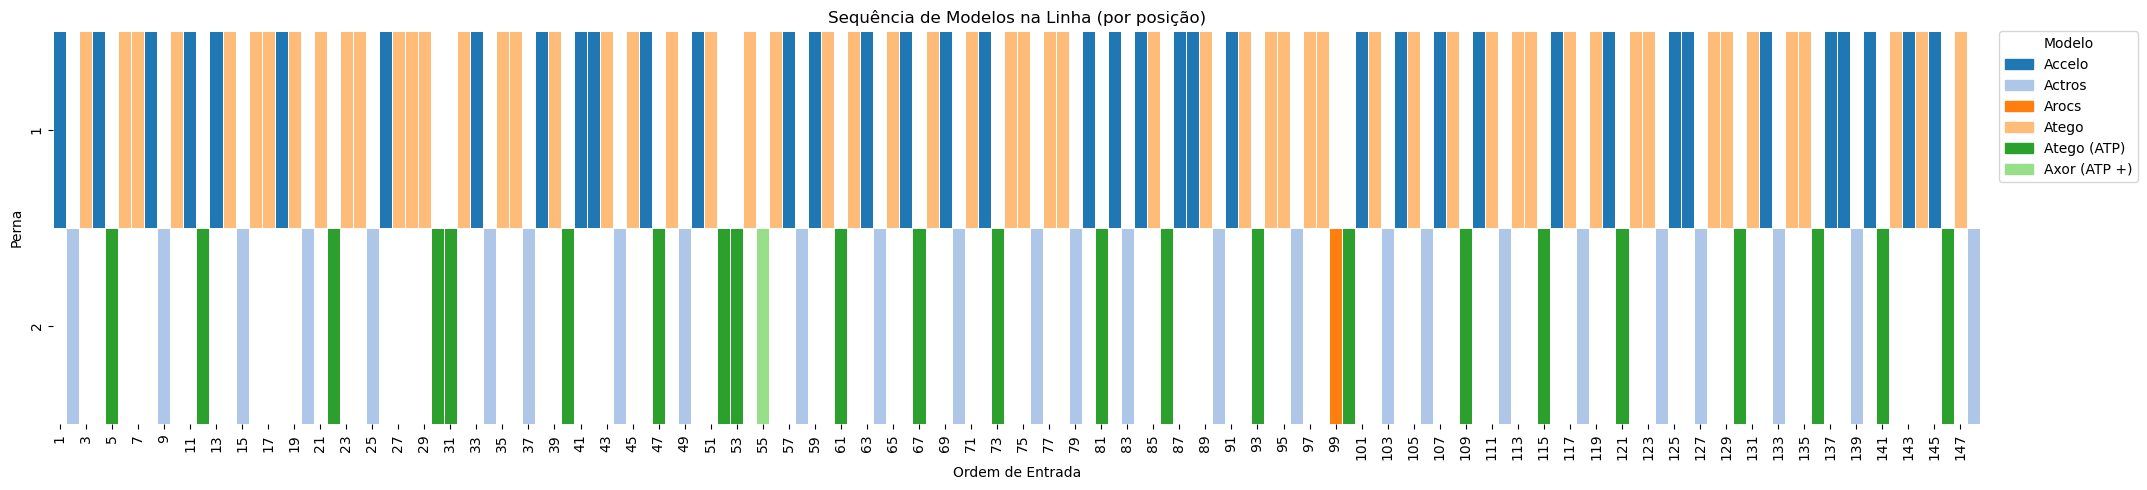

C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C1_ATP/2025-04-15/log_2025-04-15.csv
📝 PDF salvo em: logs_C1_ATP/2025-04-15/resumo_simulacao.pdf

🔄 Processando o dia: 2025-04-16
Primeiros registros do dia ordenados:
       Data Entrada Linha         Baumuster Baumuster_7dig
23489 2025-04-16 05:47:24  C9511041246 1017        C951104
12803 2025-04-16 06:03:34  C9511111246 1317        C951111
29905 2025-04-16 06:09:58         C96811412        C968114
9910  2025-04-16 06:14:53  C9634251233 2545        C963425
8380  2025-04-16 06:23:54  C9515141236 2730        C951514
17014 2025-04-16 06:33:52   C9511021239 817        C951102
27719 2025-04-16 06:40:30  C9640161215 3351        C964016
4027  2025-04-16 06:46:00       C9515111274        C951511
31993 2025-04-16 06:50:30   C9511021246 817        C951102
27717 2025-04-16 06:56:03  C9634251233 2545        C963425


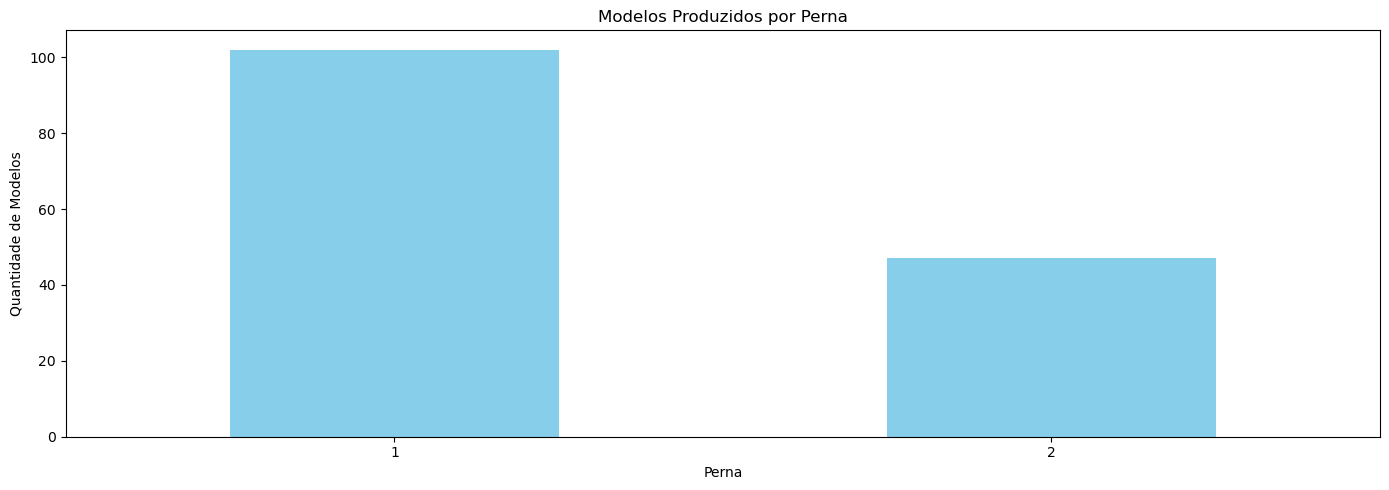

modelo
Atego          54
Accelo         48
Actros         24
Atego (ATP)    22
Arocs           1
Name: nome, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_12816\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       7626.0
1      Accelo_1  Accelo      1          660.0       9209.0
2    Accelo_103  Accelo      1        34688.0      35302.0
3    Accelo_105  Accelo      1        35348.0      35917.0
4    Accelo_108  Accelo      1        36338.0      36907.0
..          ...     ...    ...            ...          ...
144    Atego_83   Atego      1        28088.0      28716.0
145    Atego_85   Atego      1        28748.0      29376.0
146    Atego_87   Atego      1        29408.0      30036.0
147    Atego_95   Atego      1        32048.0      32676.0
148    Atego_98   Atego      1        33038.0      33666.0

[149 rows x 5 columns]


C:\Users\User\AppData\Local\Temp\ipykernel_12816\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


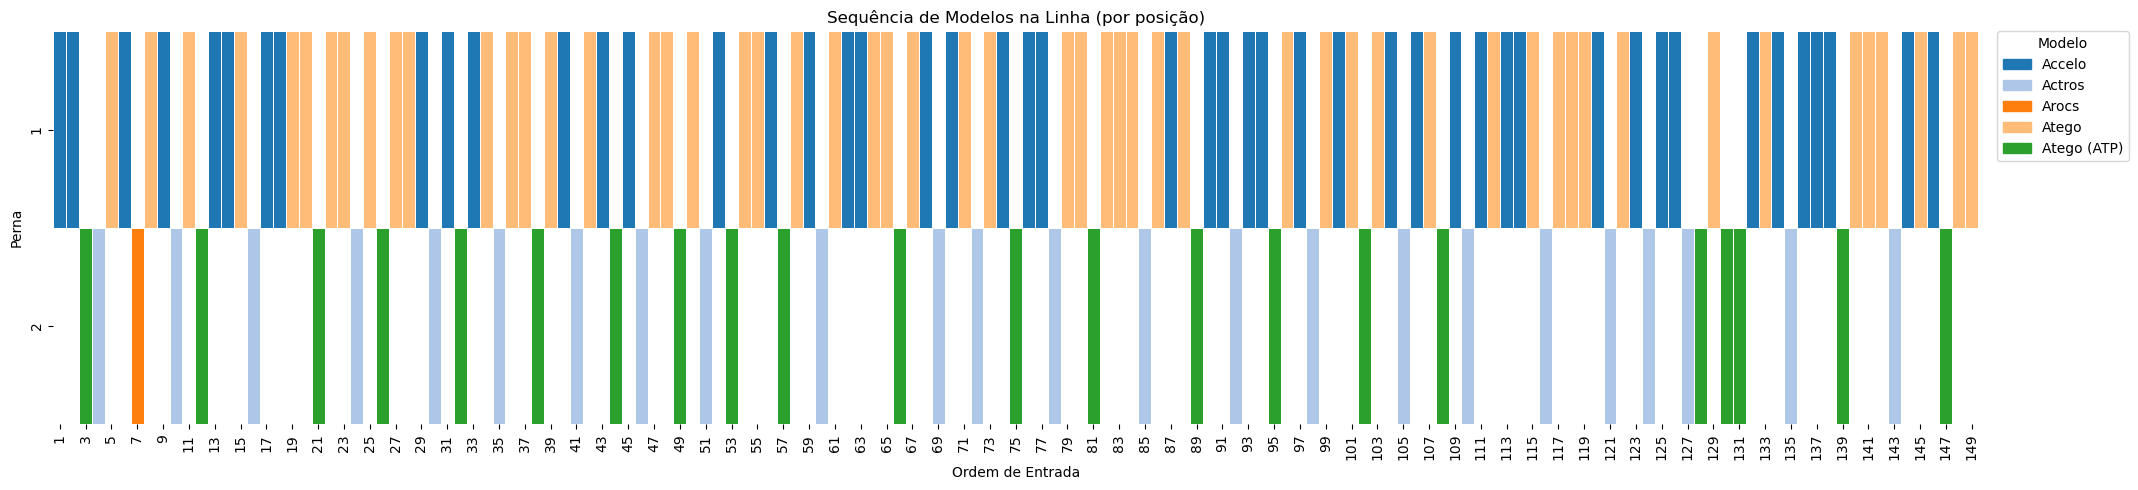

C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C1_ATP/2025-04-16/log_2025-04-16.csv
📝 PDF salvo em: logs_C1_ATP/2025-04-16/resumo_simulacao.pdf


In [30]:

# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("sequencias_entrada_linha.xlsx")

# Converte a coluna de data/hora
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'], errors='coerce')

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 10)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.dropna().unique())

# Filtra os dias a partir da data de início e pega os N primeiros
N_DIAS = 5
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:N_DIAS]

print(f"🗓️ Dias selecionados ({N_DIAS} a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_C1_ATP", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_C1_ATP/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_C1_ATP/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # --------- 🔧 AQUI ESTÁ A MUDANÇA IMPORTANTE ---------
    # Filtra dados do dia e ORDENA por Data Entrada Linha (data+hora)
    df_dia = (
        df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia]
        .copy()
        .sort_values('Data Entrada Linha', ascending=True)
    )

    # Extrai os 7 primeiros dígitos do Baumuster (removendo espaços perdidos)
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str.strip().str[:7]

    # Agora a sequência está na ordem correta (crescente por horário daquele dia)
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()
    # ------------------------------------------------------

    # (Opcional) print de conferência
    print("Primeiros registros do dia ordenados:")
    print(df_dia[['Data Entrada Linha', 'Baumuster', 'Baumuster_7dig']].head(10))

    # Simula
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento
    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png", dpi=300, bbox_inches="tight")
    plt.close(fig1)

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png", dpi=300, bbox_inches="tight")
    plt.close(fig2)

    # figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    # for i, fig in enumerate(figs, start=1):
    #     fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
    #     plt.close(fig)
    
    # figs = plot_duracao_media_por_posto(df_log)
    # for i, fig in enumerate(figs, start=1):
    #     fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
    #     plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)

    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")

    # (Opcional) Salva PDF com o resumo
    caminho_pdf = f"{pasta_dia}/resumo_simulacao.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf)